# Importing libraries

In [1]:
import os
import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA              

C:\Users\prate\anaconda3\envs\my-rdkit-env1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_parity(y_true, y_pred, y_pred_unc=None):
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.xlabel('True')
    plt.ylabel('Chemprop Predicted')
    
    plt.show()
    
    return

# Generating RDKit descriptors

In [3]:
# import pandas as pd
# import numpy as np

# X_train=pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
# X_train = X_train.drop(['PCE_max(%)'], axis = 1)
# X_train

# X_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
# X_val = X_val.drop(['PCE_max(%)'], axis = 1)
# X_val

# X_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
# X_test = X_test.drop(['PCE_max(%)'], axis = 1)
# X_test

# # rdkit desciptors for test set


# from rdkit.Chem import Descriptors
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole

# from rdkit.ML.Descriptors import MoleculeDescriptors
# des_list = [x[0] for x in Descriptors._descList]


# def rdkit_des(D,A):

#     mols = [ Chem.MolFromSmiles(x) for x in D_smiles if x != None ]
#     desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
#     values_rdkit_donor = [desc_calc.CalcDescriptors(mol) for mol in mols]
#     values_rdkit_donor

#     df_rdkit_donor = pd.DataFrame(values_rdkit_donor, columns=des_list)
#     df_rdkit_donor

#     df_rdkit_donor=df_rdkit_donor.add_prefix('Donor_')
#     df_rdkit_donor


#     mols = [ Chem.MolFromSmiles(x) for x in A_smiles if x != None ]
#     desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
#     values_rdkit_acceptor = [desc_calc.CalcDescriptors(mol) for mol in mols]
#     values_rdkit_acceptor


#     df_rdkit_acceptor = pd.DataFrame(values_rdkit_acceptor, columns=des_list)
#     df_rdkit_acceptor


#     df_rdkit_acceptor=df_rdkit_acceptor.add_prefix('Acceptor_')
#     df_rdkit_acceptor


#     frames =[df_rdkit_donor, df_rdkit_acceptor]
#     rdkit_descriptors = pd.concat(frames, axis =1)
#     return rdkit_descriptors


# D_smiles = X_train["p(SMILES)"]
# A_smiles = X_train["n(SMILES)"]
# X_train_rdkit = rdkit_des(D_smiles,A_smiles)

# D_smiles = X_val["p(SMILES)"]
# A_smiles = X_val["n(SMILES)"]
# X_val_rdkit = rdkit_des(D_smiles,A_smiles)

# D_smiles = X_test["p(SMILES)"]
# A_smiles = X_test["n(SMILES)"]
# X_test_rdkit = rdkit_des(D_smiles,A_smiles)

# X_train_rdkit.to_csv('X_train_rdkit.csv')
# X_val_rdkit.to_csv('X_val_rdkit.csv')
# X_test_rdkit.to_csv('X_test_rdkit.csv')

# Using saved files for RDKit descriptors

In [4]:
import pandas as pd
import numpy as np

X_train_rdkit=pd.read_csv('X_train_rdkit.csv')
X_val_rdkit=pd.read_csv('X_val_rdkit.csv')
X_test_rdkit=pd.read_csv('X_test_rdkit.csv')

In [5]:
X_train_rdkit=X_train_rdkit.drop(['Donor_Ipc','Acceptor_Ipc'],axis=1)
X_val_rdkit=X_val_rdkit.drop(['Donor_Ipc','Acceptor_Ipc'],axis=1)
X_test_rdkit=X_test_rdkit.drop(['Donor_Ipc','Acceptor_Ipc'],axis=1)

In [6]:
all_data = pd.concat([X_train_rdkit,X_val_rdkit,X_test_rdkit])

all_data=all_data.select_dtypes(include='number')  
print('Features with zero standard deviation :',len(all_data.std()[all_data.std() == 0])) #displaying features with zero std deviation
all_data=all_data.drop(all_data.std()[all_data.std() == 0].index.values, axis=1)  # Dropping features with zero std deviation
all_data = all_data.replace([np.inf, -np.inf], np.nan)
all_data = all_data.replace(np.nan,0)  #replace null values with zero

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr
corr_features = correlation(all_data, 0.8)
print('Features with correlation more than 0.8 :',len(set(corr_features)))
all_data=all_data.drop(corr_features,axis=1)   # Dropping features with correlation more than 0.8

Features with zero standard deviation : 114
Features with correlation more than 0.8 : 171


In [7]:
X_train_rdkit=X_train_rdkit[all_data.columns]
X_train_rdkit = X_train_rdkit.replace([np.inf, -np.inf], np.nan)
X_train_rdkit = X_train_rdkit.replace(np.nan,0)  #replace null values with zero

X_val_rdkit=X_val_rdkit[all_data.columns]
X_val_rdkit = X_val_rdkit.replace([np.inf, -np.inf], np.nan)
X_val_rdkit = X_val_rdkit.replace(np.nan,0)  #replace null values with zero

X_test_rdkit=X_test_rdkit[all_data.columns]
X_test_rdkit = X_test_rdkit.replace([np.inf, -np.inf], np.nan)
X_test_rdkit = X_test_rdkit.replace(np.nan,0)  #replace null values with zero

In [8]:
# Defining Metrics
def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2
def PearsonCoefficient(X, Y):
    corr, _ = pearsonr(X,Y)
    return corr
def MSE(X,Y):
    mse=mean_squared_error(X,Y)
    return mse
def RMSE(X,Y):
    rmse=np.sqrt(mean_squared_error(X,Y))
    return rmse
def MAPE(X,Y):
    mape=np.average(abs(np.array(X)-np.array(Y))/np.array(Y))*100
    return mape


from sklearn.metrics import r2_score
import sklearn.metrics as metrics
from scipy.stats.stats import pearsonr

In [9]:
y_train=pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
y_train = y_train.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

y_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
y_val = y_val.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

y_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
y_test = y_test.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

In [ ]:
# from sklearn.model_selection import GridSearchC
# param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'min_child_weight': [4],
#               'subsample': [0.8],
#               'colsample_bytree': [0.8],
#               'n_estimators': [50,100,150,200,250,300]}
# print(param_grid)

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the grid
param_grid = {'n_estimators': [50,100,150,200,250,300],
          'learning_rate': [0.01, 0.05, 0.1],
          'max_depth': [3, 5, 7],
          'subsample': [0.6, 0.8, 1],
          'colsample_bytree': [0.6, 0.8, 1]}
print(param_grid)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor()
tune_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
tune_xgb.fit(X_train_rdkit, y_train)
# print clf.best_score_
tune_xgb.best_params_


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
 
 # create regressor object
regressor = XGBRegressor(**tune_xgb.best_params_,random_state = 42)
 
# fit the regressor with x and y data
regressor.fit(X_train_rdkit, y_train) 

pred = regressor.predict(X_test_rdkit)
y_test = y_test.to_numpy().ravel()

# Or use the saved model

In [10]:
import pickle
with open('./Models/rdkit_xgboost.pkl', 'rb') as f:
    regressor = pickle.load(f)
    
# fit the regressor with x and y data
regressor.fit(X_train_rdkit, y_train) 

pred = regressor.predict(X_test_rdkit)
y_test = y_test.to_numpy().ravel()

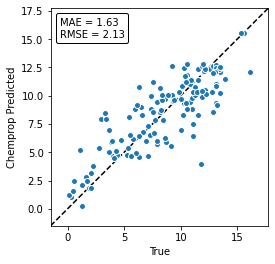

In [11]:
plot_parity(y_test, pred)

In [12]:
print('Pearson r: ',PearsonCoefficient(y_test, pred))
print('R2 Score: ',R2Score(y_test, pred))

Pearson r:  0.829807162559819
R2 Score:  0.6883724141817946


In [13]:
import numpy as np
RMSE(y_test, pred)

2.1321059638026596

In [14]:
import plotly
import plotly.graph_objs as go

In [15]:
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)

layout0= go.Layout(title= "PCE", hovermode= 'closest',
                   font = dict(family='Times New Roman',size=28),
                   xaxis= dict(title= 'Reported PCE (%)',zeroline= False, gridwidth= 1, dtick=2),
                   yaxis= dict(title= 'Predicted PCE (%)',zeroline= False, gridwidth= 1),#range=[-350,3750]),
                   height=600,
                   width=800,
                   showlegend= True                 
)

fit  = np.linspace(min(y_test), max(y_test))
trace0 = go.Scatter(x = y_test, y = pred, mode = 'markers', marker= dict(size= 12, color= 'blue'),name='Test Data')
# trace1 = go.Scatter(x = test_outputs ,y = y_pred, mode = 'markers', text=test_inputs.index,marker= dict(size= 12, color= 'red'), 
#                     error_y = dict(type='data',array=y_std,visible=True),name='Testing Data')
trace2 = go.Scatter(x = fit ,y = fit, mode = 'lines', marker= dict(size= 12, color= 'black'), text = 'Fit',name='Linear Fit')

data = [trace0,trace2]
fig= go.Figure(data, layout=layout0)
iplot(fig)

# Save the model

In [ ]:
# import pickle
# with open('rdkit_xgboost.pkl', 'wb') as f:
#     pickle.dump(regressor, f)